## Training and evaluation of automated detection and lateralisation of HS 

This notebook is used to create the results of Table 2 and Supplementary Table of the manuscript

It trains a logistic regression model at classifying hippocampi in left HS , right HS and no HS class. The resulting scores are used to evaluate the model at detecting HS (i.e differentiating patients vs controls) and lateralising the side of the abnormality

The model is evaluated using Leave-one-site-out cross-validation

Performances of the model are breakdown into factor such as age group, sex, histopathologies, and MRI status (e.g MRI negative)


In [1]:
import sys
import os
import pandas as pd
import numpy as np 

from aidhs.paths import BASE_PATH
from aidhs.aidhs_cohort_hip import AidhsCohort, AidhsSubject
from aidhs.train_evaluate import prepare_dataset
import matplotlib.pyplot as plt

Setting DATA_PATH to /home/mathilde/Documents/projects/surHippo/processes/230315_preprocess_manuscript
Setting BASE_PATH to /home/mathilde/Documents/projects/surHippo/processes/230315_preprocess_manuscript
Setting EXPERIMENT_PATH to /home/mathilde/Documents/projects/surHippo/processes/230315_preprocess_manuscript/models
Setting PARAMS_PATH to /home/mathilde/Documents/projects/surHippo/processes/230315_preprocess_manuscript
Setting FS_SUBJECTS_PATH to 
Setting HIPPUNFOLD_SUBJECTS_PATH to 
Setting BIDS_SUBJECTS_PATH to 


### Create dataset

In [2]:
#create cohort
cohort= AidhsCohort(hdf5_file_root='{site_code}_{group}_featurematrix_norm_avg.hdf5', dataset='dataset_C-P-DC_alltrain.csv')

#features
base_features=[
    '.label-{}.curvature.sm1',
    '.label-{}.gauss-curv_filtered_sm1',
    '.label-{}.gyrification.sm1',
    '.label-{}.thickness.sm1',
    '.label-avg.hippunfold_volume_icvcorr',
    '.label-avg.FS_volume_icvcorr',
    ]

features = ['.inter_z.asym.combat'+feature.format('avg') for feature in base_features]
features = features + ['.inter_z.combat'+feature.format('avg') for feature in base_features]

In [ ]:
df = prepare_dataset(features, cohort)

In [18]:
# add raw freesurfer volumes

cohort_raw= AidhsCohort(hdf5_file_root='{site_code}_{group}_featurematrix_smoothed_avg.hdf5', dataset='dataset_C-P-DC_alltrain.csv')


feature = '.label-avg.FS_volume_icvcorr'
volumes = []
for i, row in df.iterrows():
    subj = AidhsSubject(row['ID'], cohort=cohort_raw) 
    vals = subj.load_feature_values(feature, row['hemi'])[0]
    volumes.append(vals)
df[feature] = volumes

In [6]:
# add histopathology
import numpy as np

def isNaN(num):
    return num != num

#add histopathologie 
histos = []
for i,row in df.iterrows():
    # print(id)
    subj=AidhsSubject(row['ID'],cohort)
    if row['group']=='P':
        # print(histo)
        histo = subj.get_demographic_features(['histology'])[0]
        if isNaN(histo):
            histos.append('non spec')
            # histos.append(np.nan)
        elif 'HS type 1' in histo:
            histos.append('HS type 1')
        elif 'HS type 2' in histo:
            histos.append('HS type 2')
        elif 'HS type 3' in histo:
            histos.append('HS type 3')
        else:
            histos.append('non spec')
    else:
        histos.append(np.nan)
df['histo']=histos

In [3]:
#load or save matrix
output_path=os.path.join(BASE_PATH,'data_saved')
file = os.path.join(output_path,'matrix_norm_avg_230920.csv')   
# df.to_csv(file)
df=pd.read_csv(file, header=0,encoding='unicode_escape', index_col=0)

In [4]:
df.groupby(['group','histo','hemi'])['ID'].count()

group  histo      hemi
P      HS type 1  lh      60
                  rh      60
       HS type 2  lh      29
                  rh      29
       HS type 3  lh       7
                  rh       7
       non spec   lh      56
                  rh      56
Name: ID, dtype: int64

In [5]:
df.groupby(['group','hemi',])['ID'].count()

group  hemi
C      lh      121
       rh      121
DC     lh       90
       rh       90
P      lh      152
       rh      152
Name: ID, dtype: int64

In [11]:
df.groupby(['group','site', 'hemi',])['ID'].count()

group  site  hemi
C      H1    lh      91
             rh      91
       H29   lh      30
             rh      30
DC     H1    lh      27
             rh      27
       H11   lh      33
             rh      33
       H16   lh      30
             rh      30
P      H1    lh      22
             rh      22
       H11   lh      72
             rh      72
       H16   lh      13
             rh      13
       H29   lh      45
             rh      45
Name: ID, dtype: int64

### Train classifier

In [6]:
import os
import numpy as np
from aidhs.train_evaluate import  ModelLogR, cross_validation_training, prepare_train_test_data, compute_performances, get_lateralisation_performances, get_differentiation_performances
from aidhs.paths import BASE_PATH

In [7]:
OUTPUT_PATH = os.path.join(BASE_PATH,'images')

In [8]:
# Define the different set of input features to use
x_categories = {
'Hippunfold features':[ 
    '.inter_z.asym.combat.label-avg.curvature.sm1',
    '.inter_z.asym.combat.label-avg.gauss-curv_filtered_sm1',
    '.inter_z.asym.combat.label-avg.gyrification.sm1',
    '.inter_z.asym.combat.label-avg.thickness.sm1',
    '.inter_z.asym.combat.label-avg.hippunfold_volume_icvcorr',
    ],

'FS volume preprocessed':[
    '.inter_z.asym.combat.label-avg.FS_volume_icvcorr',
    ],

'FS volume raw':[
    '.label-avg.FS_volume_icvcorr',
    ],
    
}

In [9]:

# initialise the set of features to run training on 
methods = ['Hippunfold features', 'FS volume preprocessed', 'FS volume raw']

#initialise the sites and dataset to use
sites=['H11', 'H16', 'H1','H29']
file_split = os.path.join(os.path.join(BASE_PATH,'dataset_C-P-DC_alltrain.csv'))

#initialise the model
model_name = 'LogReg'
model = ModelLogR(seed_model=0)
lateralisation_only = False
differentiation_only = False

#initialise path to save models
output_path= os.path.join(os.path.join(BASE_PATH,'data_saved'))

data_method={}
results_method={}
for method in methods:

    print(f'\n Preparation of data for method {method}')
    data_method[method]={}
    
    #preparation of the train and test data
    data_method[method]['train_dataset']= prepare_train_test_data(df,  file_split, x_categories[method],
                                                                mode='train',
                                                                lateralisation_only=lateralisation_only, 
                                                                differentiation_only=differentiation_only)
    #TRAIN AND EVALUATE WITH LEAVE ONE SITE OUT
    print(f'\n Running training and evaluate')
    train_dataset = data_method[method]['train_dataset']
    #create splits based on one site out
    splits = []
    for site in sites:
        # initialise site out
        train_index = np.array(train_dataset['df']['site']['lh']!=site)
        test_index = np.array(train_dataset['df']['site']['lh']==site)
        splits.append(np.array([train_index,test_index])) 
    #train and evaluate   
    scores,y_pred, clfs = cross_validation_training(train_dataset['X'], train_dataset['Y'], model, splits=splits)
    # #save classifiers
    # for i in range(0,len(sites)):
    #     filename = os.path.join(output_path,f'model_{model_name}_{method}_{sites[i]}.sav')
    #     joblib.dump(clfs[i], filename) 

    #COMPUTE PERFORMANCES
    results_method[method] = compute_performances(train_dataset['Y'], train_dataset['y_bin'], y_pred, scores)
    
    #add lateralisation performances
    results_method[method]['predict_side'], results_method[method]['accurately_lateralised'], results_method[method]['scores_lateralised'] = get_lateralisation_performances(train_dataset['Y'], scores)

    #add detection performances
    results_method[method]['predict_group'], results_method[method]['accurately_differentiated'], results_method[method]['scores_differentiated'] = get_differentiation_performances(train_dataset['Y'], scores)
    


 Preparation of data for method Hippunfold features
Classes = ['control' 'lh_ipsi' 'rh_ipsi']
There is 363 subject for training
number ipsi lh: 81
number ipsi rh: 71
number control: 211

 Running training and evaluate

 Preparation of data for method FS volume preprocessed
Classes = ['control' 'lh_ipsi' 'rh_ipsi']
There is 363 subject for training
number ipsi lh: 81
number ipsi rh: 71
number control: 211

 Running training and evaluate

 Preparation of data for method FS volume raw
Classes = ['control' 'lh_ipsi' 'rh_ipsi']
There is 363 subject for training
number ipsi lh: 81
number ipsi rh: 71
number control: 211

 Running training and evaluate


### Compare methods with ROC curves

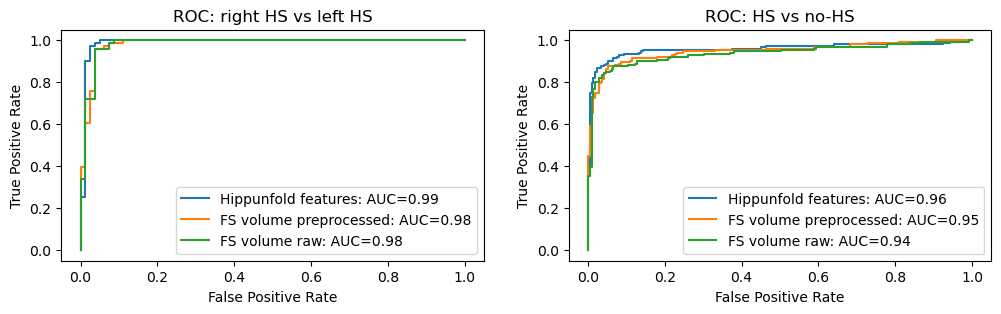

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

fig, axs = plt.subplots(1,2,figsize=(12,3))
for method in methods:
    
    #lateralisation
    y = data_method[method]['train_dataset']['Y']
    scores = np.array(results_method[method]['scores_lateralised'])
    mask =  (y!=0)
    new_y = np.array([0 if yy==1 else 1 for yy in y])
    fpr, tpr, _ = roc_curve(new_y[mask], scores[mask][:,1])
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr,tpr, label=f'{method}: AUC={round(roc_auc,2)}')
    axs[0].set_title('ROC: right HS vs left HS')
    axs[0].legend(loc='lower right')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    
    #differentiation
    y = data_method[method]['train_dataset']['Y']
    scores = np.array(results_method[method]['scores_differentiated'])
    new_y = np.array([0 if yy==0 else 1 for yy in y])
    fpr, tpr, _ = roc_curve(new_y, scores[:,1])
    roc_auc = auc(fpr, tpr)
    axs[1].plot(fpr,tpr, label=f'{method}: AUC={round(roc_auc,2)}')
    axs[1].set_title('ROC: HS vs no-HS')
    axs[1].legend(loc='lower right')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')

# fig.savefig(f'{OUTPUT_PATH}/roc_curves_methods_rawT1_clipsigma_newdataset.png', dpi=96, transparent =True, bbox_inches = 'tight')

### Evaluation overall performances

classification report for method Hippunfold features:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       211
           1       0.89      0.88      0.88        81
           2       0.93      0.90      0.91        71

    accuracy                           0.92       363
   macro avg       0.91      0.91      0.91       363
weighted avg       0.92      0.92      0.92       363

classification report for method FS volume preprocessed:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       211
           1       0.88      0.85      0.87        81
           2       0.86      0.87      0.87        71

    accuracy                           0.90       363
   macro avg       0.89      0.88      0.88       363
weighted avg       0.90      0.90      0.90       363

classification report for method FS volume raw:
              precision    recall  f1-score   support

           0       0.91 

<Figure size 640x480 with 0 Axes>

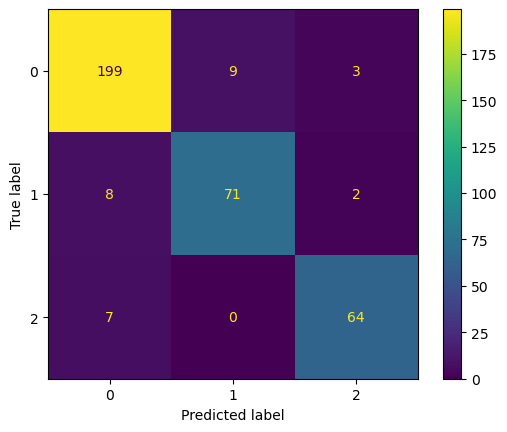

<Figure size 640x480 with 0 Axes>

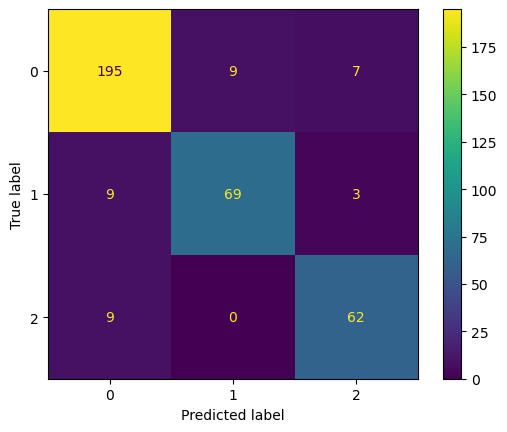

<Figure size 640x480 with 0 Axes>

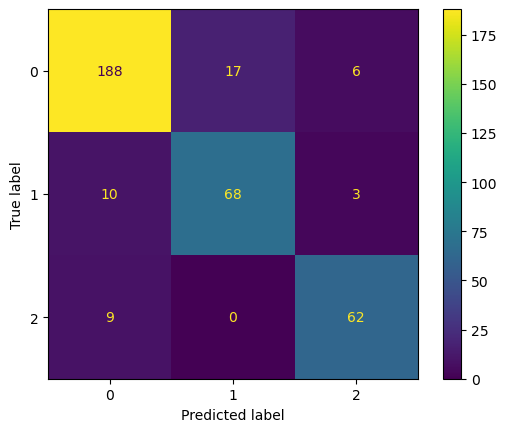

In [12]:
# Look at confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for method in methods:
    print(f'classification report for method {method}:')
    print(classification_report(data_method[method]['train_dataset']['Y'],results_method[method]['predictions']))
    plt.figure()
    cm = confusion_matrix(data_method[method]['train_dataset']['Y'],results_method[method]['predictions'])
    ConfusionMatrixDisplay(cm).plot()

In [13]:
#comparison of overall performances per methods

for method in methods:
    print(f'\nResults for method {method}')
    datatrain=data_method[method]['train_dataset']['df']

    try:
        print('\nPerformances lateralisation only:')
        datatrain[f'TP_side'] = results_method[method]['accurately_lateralised']
        
        n_tot = len(datatrain[(datatrain['group']['lh']=='P')])
        if n_tot>0:   
            n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['TP_side']==True)])
            print(f'TP in HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

    except:
        pass

    try:
        print('\nPerformances differentiation only:')
        datatrain[f'TP_group'] = results_method[method]['accurately_differentiated']

        n_tot = len(datatrain)
        if n_tot>0:
            n_tp = len(datatrain[(datatrain['TP_group']==True)])
            print(f'TP differentiating: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

        n_tot = len(datatrain[(datatrain['group']['lh']!='P')])
        if n_tot>0:
            n_tp = len(datatrain[(datatrain['group']['lh']!='P')&(datatrain['TP_group']==True)])
            print(f'TP detecting controls: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

        n_tot = len(datatrain[(datatrain['group']['lh']=='P')])
        if n_tot>0:   
            n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['TP_group']==True)])
            print(f'TP detecting HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
    except:
        pass


Results for method Hippunfold features

Performances lateralisation only:
TP in HS: 148/152 (97.4%)

Performances differentiation only:
TP differentiating: 336/363 (92.6%)
TP detecting controls: 199/211 (94.3%)
TP detecting HS: 137/152 (90.1%)

Results for method FS volume preprocessed

Performances lateralisation only:
TP in HS: 144/152 (94.7%)

Performances differentiation only:
TP differentiating: 329/363 (90.6%)
TP detecting controls: 195/211 (92.4%)
TP detecting HS: 134/152 (88.2%)

Results for method FS volume raw

Performances lateralisation only:
TP in HS: 145/152 (95.4%)

Performances differentiation only:
TP differentiating: 321/363 (88.4%)
TP detecting controls: 188/211 (89.1%)
TP detecting HS: 133/152 (87.5%)


### Evaluation breakdown per age, sex, histopathologies, MRI status, sites, control group

In [13]:
#breakdown per mri-neg

method = 'Hippunfold features' 
datatrain=data_method[method]['train_dataset']['df']

try:
    print('\nPerformances lateralisation only:')
    datatrain[f'TP_side'] = results_method[method]['accurately_lateralised']
    
    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['mri_neg']['lh']==1.0)])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['mri_neg']['lh']==1.0)&(datatrain['TP_side']==True)])
        print(f'TP in MRI negative HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
    
    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['mri_neg']['lh']==0.0)])
    if n_tot>0:
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['mri_neg']['lh']==0.0)&(datatrain['TP_side']==True)])
        print(f'TP in MRI positive HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
except:
    pass

try:
    print('\nPerformances differentiation only:')
    datatrain[f'TP_group'] = results_method[method]['accurately_differentiated']

    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['mri_neg']['lh']==1.0)])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['mri_neg']['lh']==1.0)&(datatrain['TP_group']==True)])
        print(f'TP detecting MRI negative HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['mri_neg']['lh']==0.0)])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['mri_neg']['lh']==0.0)&(datatrain['TP_group']==True)])
        print(f'TP detecting MRI positive HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
except:
    pass


Performances lateralisation only:
TP in MRI negative HS: 22/24 (91.7%)
TP in MRI positive HS: 126/128 (98.4%)

Performances differentiation only:
TP detecting MRI negative HS: 19/24 (79.2%)
TP detecting MRI positive HS: 118/128 (92.2%)


In [14]:
#breakdown per sex in patients    

method = 'Hippunfold features' 
datatrain=data_method[method]['train_dataset']['df']

#combine datatrain with sex
datatrain['sex'] = [df[df['ID']==subject]['sex'].values[0] for subject in datatrain.index]

#print performances per sex
print('\nPerformances lateralisation only:')
datatrain[f'TP_side'] = results_method[method]['accurately_lateralised']
for sex in [0.0, 1.0]:
    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['sex']==sex)])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')& (datatrain['sex']==sex)&(datatrain['TP_side']==True)])
        print(f'TP in sex {sex}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

print('\nPerformances differentiation only:')
datatrain[f'TP_group'] = results_method[method]['accurately_differentiated']
        
for sex in [0.0, 1.0]:
    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['sex']==sex)])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['sex']==sex)&(datatrain['TP_group']==True)])
        print(f'TP in sex {sex}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')


Performances lateralisation only:
TP in sex 0.0: 75/77 (97.4%)
TP in sex 1.0: 73/75 (97.3%)

Performances differentiation only:
TP in sex 0.0: 70/77 (90.9%)
TP in sex 1.0: 67/75 (89.3%)


In [15]:
#breakdown per controls group

method = 'Hippunfold features'
datatrain=data_method[method]['train_dataset']['df']

try:
    print('\nPerformances differentiation only:')
    datatrain[f'TP_group'] = results_method[method]['accurately_differentiated']
            
    n_tot = len(datatrain[(datatrain['group']['lh']=='C')])
    if n_tot>0:
        n_tp = len(datatrain[(datatrain['group']['lh']=='C')&(datatrain['TP_group']==True)])
        print(f'TP detecting healthy controls: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

    n_tot = len(datatrain[(datatrain['group']['lh']=='DC')])
    if n_tot>0:
        n_tp = len(datatrain[(datatrain['group']['lh']=='DC')&(datatrain['TP_group']==True)])
        print(f'TP detecting disease controls: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

except:
    pass


Performances differentiation only:
TP detecting healthy controls: 116/121 (95.9%)
TP detecting disease controls: 83/90 (92.2%)


In [16]:
#breakdown per sex in controls

method = 'Hippunfold features'   
datatrain=data_method[method]['train_dataset']['df']
    
#combine datatrain with sex
datatrain['sex'] = [df[df['ID']==subject]['sex'].values[0] for subject in datatrain.index]

print('\nPerformances differentiation only:')
datatrain[f'TP_group'] = results_method[method]['accurately_differentiated']
        
for sex in [0.0, 1.0]:
    n_tot = len(datatrain[(datatrain['group']['lh']!='P')&(datatrain['sex']==sex)])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']!='P')&(datatrain['sex']==sex)&(datatrain['TP_group']==True)])
        print(f'TP in sex {sex}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')


Performances differentiation only:
TP in sex 0.0: 74/84 (88.1%)
TP in sex 1.0: 125/127 (98.4%)


In [17]:
#breakdown per histo

method = 'Hippunfold features'
datatrain=data_method[method]['train_dataset']['df']
    
#combine datatrain with histo
datatrain['histo'] = [df[df['ID']==subject]['histo'].values[0] for subject in datatrain.index]

#print performances per histo
print('\nPerformances lateralisation only:')
datatrain[f'TP_side'] = results_method[method]['accurately_lateralised']
for histo in ['HS type 1', 'HS type 2', 'HS type 3', 'non spec']:
    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['histo']==histo)])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['histo']==histo)&(datatrain['TP_side']==True)])
        print(f'TP in {histo}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
    

print('\nPerformances differentiation only:')
datatrain[f'TP_group'] = results_method[method]['accurately_differentiated']
        
for histo in ['HS type 1', 'HS type 2', 'HS type 3', 'non spec']:
    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['histo']==histo)])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['histo']==histo)&(datatrain['TP_group']==True)])
        print(f'TP detecting {histo}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
    


Performances lateralisation only:
TP in HS type 1: 60/60 (100.0%)
TP in HS type 2: 26/29 (89.7%)
TP in HS type 3: 6/7 (85.7%)
TP in non spec: 56/56 (100.0%)

Performances differentiation only:
TP detecting HS type 1: 55/60 (91.7%)
TP detecting HS type 2: 27/29 (93.1%)
TP detecting HS type 3: 4/7 (57.1%)
TP detecting non spec: 51/56 (91.1%)


In [18]:
#breakdown per age in patients

method = 'Hippunfold features' 
datatrain=data_method[method]['train_dataset']['df']
    
#combine datatrain with age
datatrain['age'] = [df[df['ID']==subject]['age_scan'].values[0] for subject in datatrain.index]

#print performances per age
print('\nPerformances lateralisation only:')
datatrain[f'TP_side'] = results_method[method]['accurately_lateralised']
for age in [[0,18], [18, 100]]:
    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['age']>=age[0])&(datatrain['age']<age[1])])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['age']>=age[0])&(datatrain['age']<age[1])&(datatrain['TP_side']==True)])
        print(f'TP in age range {age}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

print('\nPerformances differentiation only:')
datatrain[f'TP_group'] = results_method[method]['accurately_differentiated']
        
for age in [[0,18],[18,100]]:
    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['age']>=age[0])&(datatrain['age']<age[1])])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['age']>=age[0])&(datatrain['age']<age[1])&(datatrain['TP_group']==True)])
        print(f'TP detecting {age}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
    


Performances lateralisation only:
TP in age range [0, 18]: 32/34 (94.1%)
TP in age range [18, 100]: 116/118 (98.3%)

Performances differentiation only:
TP detecting [0, 18]: 29/34 (85.3%)
TP detecting [18, 100]: 108/118 (91.5%)


In [19]:
#breakdown per site

method = 'Hippunfold features'
datatrain=data_method[method]['train_dataset']['df']
    
#combine datatrain with site
datatrain['site'] = [df[df['ID']==subject]['site'].values[0] for subject in datatrain.index]

#print performances per site
print('\nPerformances lateralisation only:')
datatrain[f'TP_side'] = results_method[method]['accurately_lateralised']
for site in ['H1', 'H11', 'H16', 'H29']:
    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['site']['lh']==site)])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['site']['lh']==site)&(datatrain['TP_side']==True)])
        print(f'TP lateralising {site}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')


print('\nPerformances differentiation only:')
datatrain[f'TP_group'] = results_method[method]['accurately_differentiated']
        
for site in ['H1', 'H11', 'H16', 'H29']:
    n_tot = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['site']['lh']==site)])
    if n_tot>0:   
        n_tp = len(datatrain[(datatrain['group']['lh']=='P')&(datatrain['site']['lh']==site)&(datatrain['TP_group']==True)])
        print(f'TP detecting {site}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')



Performances lateralisation only:
TP lateralising H1: 21/22 (95.5%)
TP lateralising H11: 69/72 (95.8%)
TP lateralising H16: 13/13 (100.0%)
TP lateralising H29: 45/45 (100.0%)

Performances differentiation only:
TP detecting H1: 18/22 (81.8%)
TP detecting H11: 67/72 (93.1%)
TP detecting H16: 12/13 (92.3%)
TP detecting H29: 40/45 (88.9%)


#### Analyse breakdown effects using multivariable linear regression 

In [20]:
# create the breakdown dataframe

subdf = data_method[method]['train_dataset']['df'][['TP_side','TP_group']]
df_breakdown=pd.DataFrame()

#add group
df_breakdown['Group'] = [df[df['ID']==subject]['group'].values[0] for subject in subdf.index]
#add age preop
df_breakdown['Age group'] = ['pediatric' if df[df['ID']==subject]['age_scan'].values[0]<18 else 'adult' for subject in subdf.index]
#add sex
df_breakdown['Sex'] = [df[df['ID']==subject]['sex'].values[0] for subject in subdf.index]
#add site
df_breakdown['Site'] = [df[df['ID']==subject]['site'].values[0] for subject in subdf.index]
#add histo
df_breakdown['Histology'] = [df[df['ID']==subject]['histo'].values[0] if df[df['ID']==subject]['group'].values[0]=='P' else np.nan for subject in subdf.index]
#add mri_neg
df_breakdown['Ever reported MRI negative'] = [df[df['ID']==subject]['mri_neg'].values[0] if df[df['ID']==subject]['group'].values[0]=='P' else np.nan for subject in subdf.index]


#add detection or lateralisation
df_breakdown['detected'] = subdf['TP_group'].values
df_breakdown['lateralised'] = subdf['TP_side'].values

df_breakdown.head()

,Group,Age group,Sex,Site,Histology,Ever reported MRI negative,detected,lateralised
0,P,adult,1.0,H11,HS type 1,0.0,True,True
1,P,pediatric,1.0,H11,HS type 2,1.0,False,True
2,P,pediatric,1.0,H11,HS type 2,1.0,True,True
3,P,adult,1.0,H11,HS type 1,0.0,False,True
4,P,adult,1.0,H11,HS type 2,0.0,True,True


In [21]:
# Predicting detection in patients with age, sex, site, MRI status and histopathologies

import statsmodels.api as smf

df_breakdown_sub = df_breakdown[df_breakdown['Group']=='P'].copy()
df_breakdown_sub = df_breakdown_sub.reset_index()

#convert categorical variables to dummy variable
df_breakdown_sub = pd.get_dummies(df_breakdown_sub, columns=['Age group', 'Sex', 'Site', 'Ever reported MRI negative','Histology'], drop_first=False)

# defining the dependent and independent variables with the reference for each category
Xtrain = df_breakdown_sub[['Age group_pediatric', 'Sex_1.0', 'Ever reported MRI negative_1.0','Histology_HS type 2','Histology_HS type 3','Histology_non spec', 'Site_H1', 'Site_H16', 'Site_H29', ]]
ytrain = df_breakdown_sub['detected'].astype(bool)

Xtrain = smf.add_constant(Xtrain)

#create model
model = smf.Logit(ytrain, Xtrain)

#fit model
res=model.fit()

#print summary
print(res.summary())

         Current function value: 0.277101
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               detected   No. Observations:                  152
Model:                          Logit   Df Residuals:                      142
Method:                           MLE   Df Model:                            9
Date:                Mon, 25 Sep 2023   Pseudo R-squ.:                  0.1399
Time:                        14:24:40   Log-Likelihood:                -42.119
converged:                      False   LL-Null:                       -48.972
Covariance Type:            nonrobust   LLR p-value:                    0.1332
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              3.5371      0.820      4.315      0.000       1.930       5.144
Age g

/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
# Predicting lateralisation in patients with age, sex, site, MRI status and histopathologies
import statsmodels.api as smf

df_breakdown_sub = df_breakdown[df_breakdown['Group']=='P'].copy()

#convert categorical variables to dummy variable
df_breakdown_sub = pd.get_dummies(df_breakdown_sub, columns=['Age group', 'Sex', 'Site', 'Ever reported MRI negative','Histology'], drop_first=False)

# defining the dependent and independent variables with the reference for each category
Xtrain = df_breakdown_sub[['Age group_pediatric', 'Sex_1.0', 'Ever reported MRI negative_1.0','Histology_HS type 2','Histology_HS type 3','Histology_non spec', 'Site_H1', 'Site_H16', 'Site_H29']]
ytrain = df_breakdown_sub['lateralised'].astype(bool)

Xtrain = smf.add_constant(Xtrain)

#create model
model = smf.Logit(ytrain, Xtrain)
#fit model
res=model.fit()

#print summary
print(res.summary())

         Current function value: 0.074840
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            lateralised   No. Observations:                  152
Model:                          Logit   Df Residuals:                      142
Method:                           MLE   Df Model:                            9
Date:                Mon, 25 Sep 2023   Pseudo R-squ.:                  0.3850
Time:                        14:24:45   Log-Likelihood:                -11.376
converged:                      False   LL-Null:                       -18.497
Covariance Type:            nonrobust   LLR p-value:                    0.1139
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             32.9327   1.21e+06   2.72e-05      1.000   -2.37e+06    2.37e+06
Age g

/home/mathilde/anaconda3/envs/neohip3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# Predicting detection in controls with control status (healthy vs disease)

import statsmodels.api as smf

df_breakdown_sub = df_breakdown[df_breakdown['Group']!='P'].copy()

#convert categorical variables to dummy variable
df_breakdown_sub = pd.get_dummies(df_breakdown_sub, columns=['Group',], drop_first=False)

# defining the dependent and independent variables with the reference for each category
Xtrain = df_breakdown_sub[['Group_DC']]
ytrain = df_breakdown_sub['detected']

Xtrain = smf.add_constant(Xtrain)

#create model
model = smf.Logit(ytrain, Xtrain)

#fit model
res=model.fit()

#print summary
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.215283
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               detected   No. Observations:                  211
Model:                          Logit   Df Residuals:                      209
Method:                           MLE   Df Model:                            1
Date:                Mon, 25 Sep 2023   Pseudo R-squ.:                 0.01370
Time:                        14:24:47   Log-Likelihood:                -45.425
converged:                       True   LL-Null:                       -46.056
Covariance Type:            nonrobust   LLR p-value:                    0.2614
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1442      0.457      6.884      0.000       2.249       4.039
Group_DC      -0.6712      0.